## ViT Model

In [ ]:
# ViT Model Training with Parameter Count, Training Time and Inference Time Tracking

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import timm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === Dataset & Augmentations ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class JetImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # C,H,W

        if self.transform:
            image = image.permute(1, 2, 0).numpy()
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# === Load data ===
data = np.load('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
X = data['X']
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = JetImageDataset(X_train, y_train, transform=train_transform)
val_dataset = JetImageDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model.to(device)

# Count Trainable Parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.head.parameters(), 'lr': 1e-4},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()

# === Utility functions ===
def unfreeze_blocks_vit(model, block_ids):
    for idx, block in enumerate(model.blocks):
        for param in block.parameters():
            param.requires_grad = (idx in block_ids)
    for param in model.head.parameters():
        param.requires_grad = True

def unfreeze_and_update_optimizer_vit(epoch, model, optimizer):
    if epoch in [5, 8]:
        print(f"Unfreezing blocks at epoch {epoch}...")
        blocks_to_unfreeze = [3] if epoch == 5 else [2, 3]
        for idx, block in enumerate(model.blocks):
            if idx in blocks_to_unfreeze:
                for param in block.parameters():
                    param.requires_grad = True

        backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'head' not in n]
        existing_param_ids = {id(p) for pg in optimizer.param_groups for p in pg['params']}
        new_params = [p for p in backbone_params if id(p) not in existing_param_ids]
        if new_params:
            optimizer.add_param_group({'params': new_params, 'lr': 1e-6})

# === Training and Evaluation Functions ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    end_time = time.time()
    return running_loss / total, correct / total, end_time - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_targets, all_preds = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    return running_loss / total, correct / total, prec, rec, f1, roc_auc, cm

# === Training Loop ===
num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
training_times = []

unfreeze_blocks_vit(model, block_ids=[])
print("Starting training with only head unfrozen.")

for epoch in range(num_epochs):
    unfreeze_and_update_optimizer_vit(epoch, model, optimizer)

    train_loss, train_acc, train_time = train_epoch(model, train_loader, nn.CrossEntropyLoss(), optimizer, device, scaler)
    val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, nn.CrossEntropyLoss(), device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    training_times.append(train_time)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_vit_finetuned.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Inference Time Measurement (per image)
model.eval()
sample = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    start_inf = time.time()
    _ = model(sample)
    end_inf = time.time()
    print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Swin Transformer

In [ ]:
# Swin Transformer Training with Parameter Count, Training Time, and Inference Time Tracking

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import timm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === Dataset & Augmentations ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class JetImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        if self.transform:
            image = image.permute(1, 2, 0).numpy()
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# === Load data ===
data = np.load('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
X = data['X']
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = JetImageDataset(X_train, y_train, transform=train_transform)
val_dataset = JetImageDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

# Count Trainable Parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.head.parameters(), 'lr': 1e-4},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()

# === Utility functions ===
def unfreeze_blocks(model, block_ids):
    for idx, layer in enumerate(model.layers):
        for param in layer.parameters():
            param.requires_grad = (idx in block_ids)
    for param in model.head.parameters():
        param.requires_grad = True

def unfreeze_and_update_optimizer(epoch, model, optimizer):
    if epoch in [5, 8]:
        print(f"Unfreezing blocks at epoch {epoch}...")
        blocks_to_unfreeze = [3] if epoch == 5 else [2, 3]
        for idx, layer in enumerate(model.layers):
            if idx in blocks_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True

        backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'head' not in n]
        existing_param_ids = {id(p) for pg in optimizer.param_groups for p in pg['params']}
        new_params = [p for p in backbone_params if id(p) not in existing_param_ids]
        if new_params:
            optimizer.add_param_group({'params': new_params, 'lr': 1e-6})

# === Training and Evaluation Functions ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    end_time = time.time()
    return running_loss / total, correct / total, end_time - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_targets, all_preds = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    return running_loss / total, correct / total, prec, rec, f1, roc_auc, cm

# === Training Loop ===
num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
training_times = []

unfreeze_blocks(model, block_ids=[])
print("Starting training with only head unfrozen.")

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    unfreeze_and_update_optimizer(epoch, model, optimizer)
    train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    training_times.append(train_time)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_swin_finetuned.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Inference Time Measurement (per image)
model.eval()
sample = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    start_inf = time.time()
    _ = model(sample)
    end_inf = time.time()
    print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## Co At Net Model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import timm

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === CoAtNet Model Setup ===
def run_training(npz_file, batch_size=32, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = timm.create_model('coatnet_1_224', pretrained=False, num_classes=2)
    model.to(device)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW([
        {'params': model.head.parameters(), 'lr': 1e-4},
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    scaler = GradScaler()

    def unfreeze_blocks(epoch):
        if epoch in [5, 8]:
            print(f"Unfreezing blocks at epoch {epoch}...")
            blocks_to_unfreeze = [3] if epoch == 5 else [2, 3]
            if hasattr(model, 'stages'):
                for idx, stage in enumerate(model.stages):
                    if idx in blocks_to_unfreeze:
                        for param in stage.parameters():
                            param.requires_grad = True
            for param in model.head.parameters():
                param.requires_grad = True
            backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'head' not in n]
            existing_ids = {id(p) for pg in optimizer.param_groups for p in pg['params']}
            new_params = [p for p in backbone_params if id(p) not in existing_ids]
            if new_params:
                optimizer.add_param_group({'params': new_params, 'lr': 1e-6})

    def train_epoch():
        model.train()
        loss_sum, correct, total = 0, 0, 0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        return loss_sum / total, correct / total

    def eval_epoch():
        model.eval()
        loss_sum, correct, total = 0, 0, 0
        all_targets, all_preds, all_probs = [], [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                with autocast():
                    out = model(x)
                    loss = criterion(out, y)
                    prob = torch.softmax(out, dim=1)[:, 1]
                loss_sum += loss.item() * x.size(0)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                all_targets.extend(y.cpu().numpy())
                all_preds.extend(pred.cpu().numpy())
                all_probs.extend(prob.cpu().numpy())
        prec = precision_score(all_targets, all_preds)
        rec = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)
        roc = roc_auc_score(all_targets, all_probs)
        cm = confusion_matrix(all_targets, all_preds)
        return loss_sum / total, correct / total, prec, rec, f1, roc, cm

    best_val_loss = float('inf'); patience = 5; counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        unfreeze_blocks(epoch)
        tr_loss, tr_acc = train_epoch()
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch()
        train_losses.append(tr_loss); val_losses.append(val_loss)
        train_accs.append(tr_acc); val_accs.append(val_acc)
        print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")
        scheduler.step()
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_coatnet_finetuned.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered."); break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')

## MaxViT Model

In [ ]:
# MaxViT Model Training with Metrics Tracking

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import timm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === Dataset & Augmentations ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class JetImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        if self.transform:
            image = image.permute(1, 2, 0).numpy()
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# === Load data ===
data = np.load('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
X = data['X']
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = JetImageDataset(X_train, y_train, transform=train_transform)
val_dataset = JetImageDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('maxvit_large_tf_224', pretrained=True, num_classes=2)
model.to(device)

# Count Trainable Parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.head.parameters(), 'lr': 1e-4},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()

# === Utility functions ===
def unfreeze_blocks(model, block_ids):
    if hasattr(model, 'stages'):
        for idx, stage in enumerate(model.stages):
            for param in stage.parameters():
                param.requires_grad = (idx in block_ids)
    for param in model.head.parameters():
        param.requires_grad = True

def unfreeze_and_update_optimizer(epoch, model, optimizer):
    if epoch in [5, 8]:
        print(f"Unfreezing blocks at epoch {epoch}...")
        blocks_to_unfreeze = [3] if epoch == 5 else [2, 3]
        if hasattr(model, 'stages'):
            for idx, stage in enumerate(model.stages):
                if idx in blocks_to_unfreeze:
                    for param in stage.parameters():
                        param.requires_grad = True

        backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'head' not in n]
        existing_param_ids = {id(p) for pg in optimizer.param_groups for p in pg['params']}
        new_params = [p for p in backbone_params if id(p) not in existing_param_ids]
        if new_params:
            optimizer.add_param_group({'params': new_params, 'lr': 1e-6})

# === Training and Evaluation ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start_time = time.time()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    end_time = time.time()
    return running_loss / total, correct / total, end_time - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_targets, all_preds = [], []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    return running_loss / total, correct / total, prec, rec, f1, roc_auc, cm

# === Training Loop ===
num_epochs = 20
best_val_loss, patience, counter = float('inf'), 5, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
training_times = []

unfreeze_blocks(model, block_ids=[])
print("Starting training with only head unfrozen.")

criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    unfreeze_and_update_optimizer(epoch, model, optimizer)
    train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    training_times.append(train_time)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_maxvit_finetuned.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Inference Time
model.eval()
sample = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    start_inf = time.time()
    _ = model(sample)
    end_inf = time.time()
    print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.tight_layout()
plt.show()


## EfficientNet Model

In [ ]:
# EfficientNet-B0 with Gradual Unfreezing and Metrics Tracking

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import timm
from torch.cuda.amp import autocast, GradScaler
import time

# === Transforms ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# === Dataset ===
class JetImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = image.permute(1, 2, 0).numpy()
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# === Data Loading ===
data = np.load('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
X, y = data['X'], data['y']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_dataset = JetImageDataset(X_train, y_train, transform=train_transform)
val_dataset = JetImageDataset(X_val, y_val, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.classifier.parameters(), 'lr': 1e-3},
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler()

# === Training Functions ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start_time = time.time()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total, time.time() - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return running_loss / total, correct / total, precision, recall, f1, roc_auc, cm

# === Unfreeze backbone ===
def unfreeze_backbone(model, optimizer, lr_backbone=1e-5):
    for param in model.parameters():
        param.requires_grad = True
    optimizer.param_groups = []
    optimizer.add_param_group({'params': model.classifier.parameters(), 'lr': 1e-3})
    backbone_params = [p for n, p in model.named_parameters() if 'classifier' not in n]
    optimizer.add_param_group({'params': backbone_params, 'lr': lr_backbone})

# === Main Training Loop ===
num_epochs = 20
criterion = nn.CrossEntropyLoss()
best_val_loss, patience, counter = float('inf'), 5, 0

for epoch in range(num_epochs):
    if epoch == 5:
        print("Unfreezing backbone...")
        unfreeze_backbone(model, optimizer, lr_backbone=1e-5)

    train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_efficientnet_b0.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Inference time
model.eval()
sample = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    start_inf = time.time()
    _ = model(sample)
    end_inf = time.time()
    print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")


## ResNet Model

In [ ]:
# ResNet-50 Training with Metrics and Gradual Unfreezing

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import timm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# === Dataset & Augmentations ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class JetImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = image.permute(1, 2, 0).numpy()
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# === Load data ===
data = np.load('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
X = data['X']
y = data['y']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = JetImageDataset(X_train, y_train, transform=train_transform)
val_dataset = JetImageDataset(X_val, y_val, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# === Model setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('resnet50', pretrained=True, num_classes=2)
model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {'params': model.get_classifier().parameters(), 'lr': 1e-4},
], weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()

# === Unfreeze Function ===
def unfreeze_blocks(model, block_ids):
    if hasattr(model, 'layer1'):
        layers = [model.layer1, model.layer2, model.layer3, model.layer4]
        for idx, layer in enumerate(layers):
            for param in layer.parameters():
                param.requires_grad = (idx in block_ids)
    for param in model.get_classifier().parameters():
        param.requires_grad = True

def unfreeze_and_update_optimizer(epoch, model, optimizer):
    if epoch in [5, 8]:
        print(f"Unfreezing blocks at epoch {epoch}...")
        blocks_to_unfreeze = [3] if epoch == 5 else [2, 3]
        layers = [model.layer1, model.layer2, model.layer3, model.layer4]
        for idx, layer in enumerate(layers):
            if idx in blocks_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True

        for param in model.get_classifier().parameters():
            param.requires_grad = True

        backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and 'get_classifier' not in n]
        existing_param_ids = {id(p) for pg in optimizer.param_groups for p in pg['params']}
        new_params = [p for p in backbone_params if id(p) not in existing_param_ids]
        if new_params:
            optimizer.add_param_group({'params': new_params, 'lr': 1e-6})

# === Train/Eval ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start_time = time.time()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total, time.time() - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_targets, all_preds = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    prec = precision_score(all_targets, all_preds)
    rec = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    return running_loss / total, correct / total, prec, rec, f1, roc_auc, cm

# === Training ===
num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
training_times = []

unfreeze_blocks(model, block_ids=[])
print("Starting training with only head unfrozen.")
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    unfreeze_and_update_optimizer(epoch, model, optimizer)
    train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    training_times.append(train_time)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet_finetuned.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# === Inference Time ===
model.eval()
sample = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    start_inf = time.time()
    _ = model(sample)
    end_inf = time.time()
    print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

# === Plot ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.tight_layout()
plt.show()


## ConvNeXt  Model

In [ ]:
# ConvNeXt Training Code

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import timm

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

def run_training(npz_file, batch_size=32, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = timm.create_model('convnext_base', pretrained=True, num_classes=2)
    model.to(device)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW([
        {'params': model.head.parameters(), 'lr': 1e-4},
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    scaler = GradScaler()

    def train_epoch():
        model.train()
        loss_sum, correct, total = 0, 0, 0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        return loss_sum / total, correct / total

    def eval_epoch():
        model.eval()
        loss_sum, correct, total = 0, 0, 0
        all_targets, all_preds, all_probs = [], [], []
        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                with autocast():
                    out = model(x)
                    loss = criterion(out, y)
                    prob = torch.softmax(out, dim=1)[:, 1]
                loss_sum += loss.item() * x.size(0)
                pred = out.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                all_targets.extend(y.cpu().numpy())
                all_preds.extend(pred.cpu().numpy())
                all_probs.extend(prob.cpu().numpy())
        prec = precision_score(all_targets, all_preds)
        rec = recall_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds)
        roc = roc_auc_score(all_targets, all_probs)
        cm = confusion_matrix(all_targets, all_preds)
        return loss_sum / total, correct / total, prec, rec, f1, roc, cm

    best_val_loss = float('inf'); patience = 5; counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        tr_loss, tr_acc = train_epoch()
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch()
        train_losses.append(tr_loss); val_losses.append(val_loss)
        train_accs.append(tr_acc); val_accs.append(val_acc)
        print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")
        scheduler.step()
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_convnext_finetuned.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered."); break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')


## RegNetY

/tmp/ipykernel_35/646423823.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable Parameters: 2984974


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.84it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 1/20 | Train Loss: 0.7166 | Val Loss: 0.6900 | 
Train Acc: 0.5873 | Val Acc: 0.6300 | Precision: 0.6239 | Recall: 0.6733 | F1: 0.6476 | ROC-AUC: 0.6690


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.92it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 2/20 | Train Loss: 0.6506 | Val Loss: 0.6415 | 
Train Acc: 0.6450 | Val Acc: 0.6514 | Precision: 0.6576 | Recall: 0.6464 | F1: 0.6519 | ROC-AUC: 0.6989


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.96it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 3/20 | Train Loss: 0.6415 | Val Loss: 0.6225 | 
Train Acc: 0.6516 | Val Acc: 0.6664 | Precision: 0.6719 | Recall: 0.6634 | F1: 0.6676 | ROC-AUC: 0.7228


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:24<00:00, 14.01it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 4/20 | Train Loss: 0.6156 | Val Loss: 0.6192 | 
Train Acc: 0.6723 | Val Acc: 0.6629 | Precision: 0.6569 | Recall: 0.6959 | F1: 0.6758 | ROC-AUC: 0.7211


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.81it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 5/20 | Train Loss: 0.6184 | Val Loss: 0.6052 | 
Train Acc: 0.6677 | Val Acc: 0.6900 | Precision: 0.6914 | Recall: 0.6973 | F1: 0.6944 | ROC-AUC: 0.7435


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:24<00:00, 14.09it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 6/20 | Train Loss: 0.6298 | Val Loss: 0.6340 | 
Train Acc: 0.6646 | Val Acc: 0.6557 | Precision: 0.6600 | Recall: 0.6563 | F1: 0.6582 | ROC-AUC: 0.7122


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:24<00:00, 14.09it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 7/20 | Train Loss: 0.6150 | Val Loss: 0.6256 | 
Train Acc: 0.6725 | Val Acc: 0.6657 | Precision: 0.7108 | Recall: 0.5700 | F1: 0.6327 | ROC-AUC: 0.7222


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:24<00:00, 14.06it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 8/20 | Train Loss: 0.6095 | Val Loss: 0.6035 | 
Train Acc: 0.6718 | Val Acc: 0.6707 | Precision: 0.6852 | Recall: 0.6436 | F1: 0.6637 | ROC-AUC: 0.7422


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:24<00:00, 14.01it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 9/20 | Train Loss: 0.6055 | Val Loss: 0.5984 | 
Train Acc: 0.6830 | Val Acc: 0.6936 | Precision: 0.7271 | Recall: 0.6294 | F1: 0.6748 | ROC-AUC: 0.7492


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.78it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 10/20 | Train Loss: 0.6006 | Val Loss: 0.6011 | 
Train Acc: 0.6886 | Val Acc: 0.6771 | Precision: 0.6819 | Recall: 0.6761 | F1: 0.6790 | ROC-AUC: 0.7416


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.96it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 11/20 | Train Loss: 0.5933 | Val Loss: 0.5887 | 
Train Acc: 0.6943 | Val Acc: 0.6943 | Precision: 0.7123 | Recall: 0.6620 | F1: 0.6862 | ROC-AUC: 0.7577


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.79it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 12/20 | Train Loss: 0.5898 | Val Loss: 0.5937 | 
Train Acc: 0.6932 | Val Acc: 0.6879 | Precision: 0.6962 | Recall: 0.6775 | F1: 0.6867 | ROC-AUC: 0.7513


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.77it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 13/20 | Train Loss: 0.5780 | Val Loss: 0.5905 | 
Train Acc: 0.7045 | Val Acc: 0.6850 | Precision: 0.6900 | Recall: 0.6832 | F1: 0.6866 | ROC-AUC: 0.7550


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.98it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 14/20 | Train Loss: 0.5780 | Val Loss: 0.5879 | 
Train Acc: 0.6986 | Val Acc: 0.6943 | Precision: 0.7130 | Recall: 0.6605 | F1: 0.6858 | ROC-AUC: 0.7589


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 14.00it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 15/20 | Train Loss: 0.5755 | Val Loss: 0.5996 | 
Train Acc: 0.7111 | Val Acc: 0.6857 | Precision: 0.7290 | Recall: 0.6011 | F1: 0.6589 | ROC-AUC: 0.7513


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.89it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 16/20 | Train Loss: 0.5935 | Val Loss: 0.6082 | 
Train Acc: 0.6873 | Val Acc: 0.6829 | Precision: 0.6534 | Recall: 0.7921 | F1: 0.7161 | ROC-AUC: 0.7396


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.94it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 17/20 | Train Loss: 0.5975 | Val Loss: 0.6084 | 
Train Acc: 0.6911 | Val Acc: 0.6836 | Precision: 0.7143 | Recall: 0.6223 | F1: 0.6652 | ROC-AUC: 0.7407


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.77it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 18/20 | Train Loss: 0.5927 | Val Loss: 0.5976 | 
Train Acc: 0.6970 | Val Acc: 0.6893 | Precision: 0.7455 | Recall: 0.5842 | F1: 0.6550 | ROC-AUC: 0.7524


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.79it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 19/20 | Train Loss: 0.5911 | Val Loss: 0.6075 | 
Train Acc: 0.7052 | Val Acc: 0.6829 | Precision: 0.6765 | Recall: 0.7129 | F1: 0.6942 | ROC-AUC: 0.7491


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/646423823.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [00:25<00:00, 13.74it/s]
/tmp/ipykernel_35/646423823.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 20/20 | Train Loss: 0.5847 | Val Loss: 0.5982 | 
Train Acc: 0.7014 | Val Acc: 0.6786 | Precision: 0.7324 | Recall: 0.5728 | F1: 0.6429 | ROC-AUC: 0.7572
Total Training Time: 10.41 minutes
Inference Time (1 sample): 10.89 ms


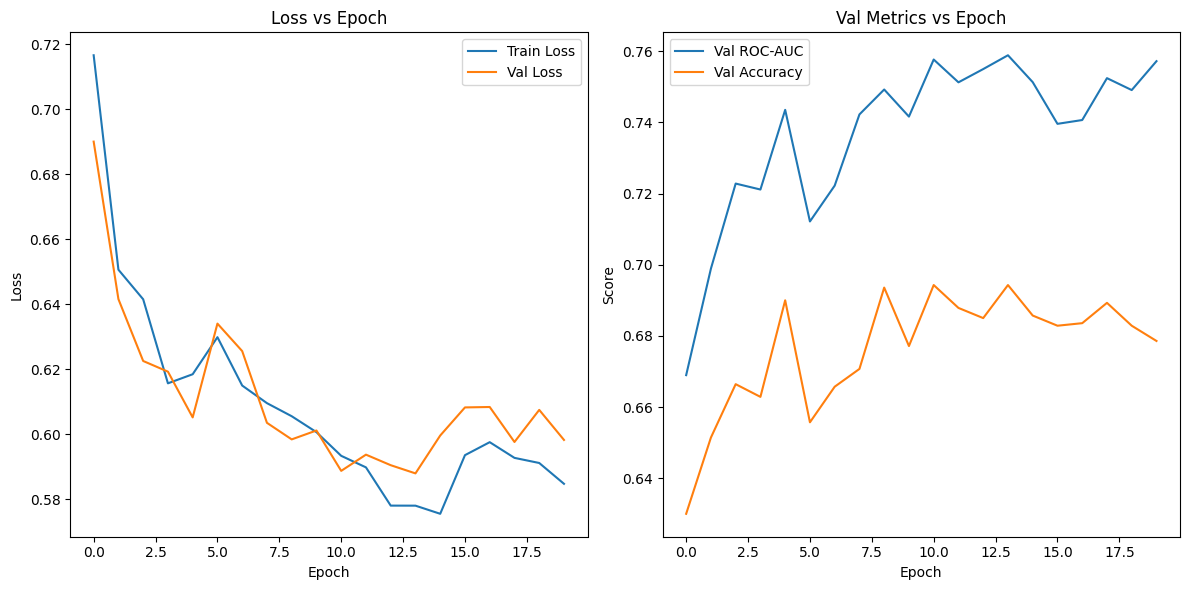

In [ ]:
# RegNetY Training with Full Metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import timm
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.75, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.3, 0.15),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class RegNetYClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.regnet = timm.create_model("regnety_002", pretrained=True)
        self.regnet.head = nn.Identity()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.regnet.num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.regnet.forward_features(x)
        x = self.pool(x)
        return self.classifier(x)

# === Training ===
def train_and_evaluate(npz_path, batch_size=16, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = RegNetYClassifier().to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {total_params}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    train_losses, val_losses, val_aucs = [], [], []
    train_accs, val_accs, precs, recalls, f1s = [], [], [], [], []
    start_train = time.time()

    for epoch in range(num_epochs):
        model.train(); epoch_loss = correct = total = 0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(imgs); loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            epoch_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        scheduler.step()
        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        # Evaluation
        model.eval(); val_loss = correct = total = 0; preds = []; probs = []; trues = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                with autocast(): outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                pred_labels = outputs.argmax(1)
                prob = torch.softmax(outputs, dim=1)[:, 1]
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)
                preds.extend(pred_labels.cpu().numpy())
                probs.extend(prob.cpu().numpy())
                trues.extend(labels.cpu().numpy())
        val_losses.append(val_loss / total)
        val_acc = correct / total
        val_auc = roc_auc_score(trues, probs)
        prec = precision_score(trues, preds)
        rec = recall_score(trues, preds)
        f1 = f1_score(trues, preds)

        val_accs.append(val_acc); val_aucs.append(val_auc)
        precs.append(prec); recalls.append(rec); f1s.append(f1)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | ")
        print(f"Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {val_auc:.4f}")

    end_train = time.time()
    print(f"Total Training Time: {(end_train - start_train)/60:.2f} minutes")

    model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(device)
        start_inf = time.time(); _ = model(dummy); end_inf = time.time()
        print(f"Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(val_aucs, label='Val ROC-AUC'); plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Val Metrics vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == '__main__':
    run_path = '/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz'
    train_and_evaluate(run_path)


## ViT + EfficientNET Hybrid

In [ ]:
!pip install efficientnet_pytorch


In [ ]:
# ViT + EfficientNet Hybrid Training with Metrics and Gradual Unfreezing

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import time

from transformers import ViTModel
from efficientnet_pytorch import EfficientNet

# === Dataset Class with augmentation and resizing ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']

        if train:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
                T.RandomHorizontalFlip(),
                T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = T.Compose([
                T.ToPILImage(),
                T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        img = self.transform(img)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label

# === Hybrid Model ViT + EfficientNet ===
class ViT_EfficientNet_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT_EfficientNet_Hybrid, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        vit_dim = self.vit.config.hidden_size
        eff_dim = self.efficientnet._fc.in_features

        self.efficientnet._fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + eff_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x)
        vit_cls = vit_outputs.pooler_output
        eff_features = self.efficientnet(x)
        combined = torch.cat((vit_cls, eff_features), dim=1)
        return self.classifier(combined)

# === Train / Eval / Utility ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start = time.time()
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total, time.time() - start

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    return running_loss / total, correct / total, precision, recall, f1, roc_auc, cm

def unfreeze_layers(model, unfreeze_vit=False, unfreeze_efficientnet=False):
    if unfreeze_vit:
        for param in model.vit.parameters():
            param.requires_grad = True
    if unfreeze_efficientnet:
        for param in model.efficientnet.parameters():
            param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

# === Main Training Loop ===
def run_training(npz_file, batch_size=16, num_epochs=15, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_EfficientNet_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    unfreeze_layers(model, unfreeze_vit=False, unfreeze_efficientnet=False)

    best_val_loss, patience, counter = float('inf'), 5, 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    training_times = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        if epoch == 5:
            print("Unfreezing ViT...")
            unfreeze_layers(model, unfreeze_vit=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.vit.parameters()), 'lr': 1e-5})
        elif epoch == 9:
            print("Unfreezing EfficientNet...")
            unfreeze_layers(model, unfreeze_vit=True, unfreeze_efficientnet=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.efficientnet.parameters()), 'lr': 1e-5})

        train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        training_times.append(train_time)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")

        scheduler.step(epoch + val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_vit_efficientnet_hybrid.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.eval()
    sample = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        start_inf = time.time()
        _ = model(sample)
        end_inf = time.time()
        print(f"\nInference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    npz_path = '/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    run_training(npz_path, batch_size=16, num_epochs=15, device=device)


## ViT + RegNetY Hybrid

/tmp/ipykernel_35/2338981583.py:84: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable Parameters: 89767438


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:02<00:00,  5.60it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 1/20
Train Loss: 0.7046 | Train Acc: 0.5887
Val Loss: 0.6381 | Val Acc: 0.6393
Precision: 0.6585 | Recall: 0.6059 | F1: 0.6311 | ROC-AUC: 0.7005


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.25it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 2/20
Train Loss: 0.6512 | Train Acc: 0.6362
Val Loss: 0.6488 | Val Acc: 0.6457
Precision: 0.6303 | Recall: 0.7363 | F1: 0.6792 | ROC-AUC: 0.7034


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.30it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 3/20
Train Loss: 0.6315 | Train Acc: 0.6595
Val Loss: 0.6494 | Val Acc: 0.6657
Precision: 0.6783 | Recall: 0.6536 | F1: 0.6657 | ROC-AUC: 0.7192


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.30it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 4/20
Train Loss: 0.6097 | Train Acc: 0.6757
Val Loss: 0.6099 | Val Acc: 0.6821
Precision: 0.6988 | Recall: 0.6606 | F1: 0.6792 | ROC-AUC: 0.7387


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.29it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 5/20
Train Loss: 0.6124 | Train Acc: 0.6727
Val Loss: 0.6045 | Val Acc: 0.6786
Precision: 0.6746 | Recall: 0.7125 | F1: 0.6930 | ROC-AUC: 0.7370


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.29it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 6/20
Train Loss: 0.6218 | Train Acc: 0.6652
Val Loss: 0.6497 | Val Acc: 0.6679
Precision: 0.6403 | Recall: 0.7938 | F1: 0.7088 | ROC-AUC: 0.7262


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.27it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 7/20
Train Loss: 0.6191 | Train Acc: 0.6654
Val Loss: 0.6148 | Val Acc: 0.6729
Precision: 0.6730 | Recall: 0.6957 | F1: 0.6841 | ROC-AUC: 0.7229


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.31it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 8/20
Train Loss: 0.6057 | Train Acc: 0.6798
Val Loss: 0.6074 | Val Acc: 0.6843
Precision: 0.6824 | Recall: 0.7111 | F1: 0.6964 | ROC-AUC: 0.7426


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:06<00:00,  5.29it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 9/20
Train Loss: 0.6005 | Train Acc: 0.6896
Val Loss: 0.5960 | Val Acc: 0.6900
Precision: 0.7025 | Recall: 0.6788 | F1: 0.6904 | ROC-AUC: 0.7476


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.37it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 10/20
Train Loss: 0.5927 | Train Acc: 0.6861
Val Loss: 0.5979 | Val Acc: 0.6814
Precision: 0.7371 | Recall: 0.5820 | F1: 0.6505 | ROC-AUC: 0.7503


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.35it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 11/20
Train Loss: 0.5849 | Train Acc: 0.6979
Val Loss: 0.6005 | Val Acc: 0.6886
Precision: 0.6993 | Recall: 0.6816 | F1: 0.6903 | ROC-AUC: 0.7433


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.35it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 12/20
Train Loss: 0.5826 | Train Acc: 0.7030
Val Loss: 0.6061 | Val Acc: 0.6821
Precision: 0.7120 | Recall: 0.6311 | F1: 0.6691 | ROC-AUC: 0.7425


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.33it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 13/20
Train Loss: 0.5795 | Train Acc: 0.7023
Val Loss: 0.6048 | Val Acc: 0.6943
Precision: 0.7230 | Recall: 0.6480 | F1: 0.6834 | ROC-AUC: 0.7374


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.32it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 14/20
Train Loss: 0.5729 | Train Acc: 0.7073
Val Loss: 0.6043 | Val Acc: 0.6771
Precision: 0.6846 | Recall: 0.6788 | F1: 0.6817 | ROC-AUC: 0.7407


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.32it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 15/20
Train Loss: 0.5680 | Train Acc: 0.7089
Val Loss: 0.5985 | Val Acc: 0.6979
Precision: 0.7054 | Recall: 0.6985 | F1: 0.7019 | ROC-AUC: 0.7492


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.33it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 16/20
Train Loss: 0.5969 | Train Acc: 0.6832
Val Loss: 0.6154 | Val Acc: 0.6893
Precision: 0.7896 | Recall: 0.5316 | F1: 0.6354 | ROC-AUC: 0.7552


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.35it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 17/20
Train Loss: 0.5900 | Train Acc: 0.6948
Val Loss: 0.6077 | Val Acc: 0.6843
Precision: 0.6799 | Recall: 0.7181 | F1: 0.6985 | ROC-AUC: 0.7378


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.36it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 18/20
Train Loss: 0.5831 | Train Acc: 0.7098
Val Loss: 0.6288 | Val Acc: 0.6586
Precision: 0.6968 | Recall: 0.5835 | F1: 0.6351 | ROC-AUC: 0.7204


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.37it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 19/20
Train Loss: 0.5812 | Train Acc: 0.7073
Val Loss: 0.6089 | Val Acc: 0.6736
Precision: 0.6557 | Recall: 0.7560 | F1: 0.7023 | ROC-AUC: 0.7403


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/2338981583.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 350/350 [01:05<00:00,  5.34it/s]
/tmp/ipykernel_35/2338981583.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): outputs = model(imgs)


Epoch 20/20
Train Loss: 0.5812 | Train Acc: 0.7073
Val Loss: 0.6005 | Val Acc: 0.6814
Precision: 0.7020 | Recall: 0.6508 | F1: 0.6754 | ROC-AUC: 0.7494
Total Training Time: 24.07 minutes
Inference Time (1 sample): 169.11 ms


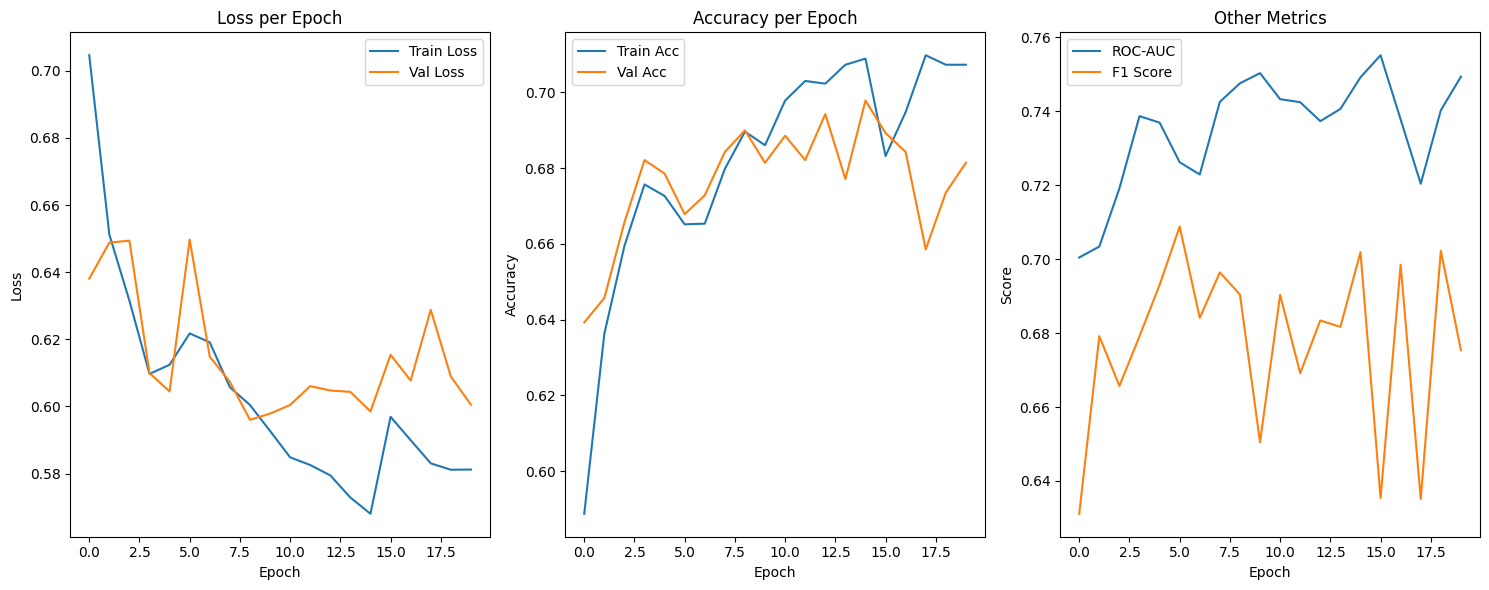

In [ ]:
# ViT + RegNetY Hybrid Training with Full Metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from transformers import ViTModel
import timm
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.75, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.3, 0.15),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_RegNetY_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.regnet = timm.create_model("regnety_002", pretrained=True)
        self.regnet.head = nn.Identity()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        vit_dim = self.vit.config.hidden_size
        regnet_dim = self.regnet.num_features

        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + regnet_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        reg_feat = self.pool(self.regnet.forward_features(x)).view(x.size(0), -1)
        return self.classifier(torch.cat((vit_cls, reg_feat), dim=1))

# === Training ===
def train_and_evaluate(npz_path, batch_size=16, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_RegNetY_Hybrid().to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters: {total_params}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    train_losses, val_losses, val_aucs = [], [], []
    train_accs, val_accs, precs, recalls, f1s = [], [], [], [], []
    start_train = time.time()

    for epoch in range(num_epochs):
        model.train(); epoch_loss = correct = total = 0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(imgs); loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            epoch_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        scheduler.step()
        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        # Evaluation
        model.eval(); val_loss = correct = total = 0; preds = []; probs = []; trues = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                with autocast(): outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                pred_labels = outputs.argmax(1)
                prob = torch.softmax(outputs, dim=1)[:, 1]
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)
                preds.extend(pred_labels.cpu().numpy())
                probs.extend(prob.cpu().numpy())
                trues.extend(labels.cpu().numpy())
        val_losses.append(val_loss / total)
        val_acc = correct / total
        val_auc = roc_auc_score(trues, probs)
        prec = precision_score(trues, preds)
        rec = recall_score(trues, preds)
        f1 = f1_score(trues, preds)

        val_accs.append(val_acc); val_aucs.append(val_auc)
        precs.append(prec); recalls.append(rec); f1s.append(f1)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {val_auc:.4f}")

    end_train = time.time()
    print(f"Total Training Time: {(end_train - start_train)/60:.2f} minutes")

    model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(device)
        start_inf = time.time(); _ = model(dummy); end_inf = time.time()
        print(f"Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss per Epoch'); plt.legend()
    plt.subplot(1, 3, 2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy per Epoch'); plt.legend()
    plt.subplot(1, 3, 3); plt.plot(val_aucs, label='ROC-AUC'); plt.plot(f1s, label='F1 Score')
    plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Other Metrics'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == '__main__':
    run_path = '/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz'
    train_and_evaluate(run_path)


## ViT + ConvNeXt Hybrid

2025-05-20 19:13:01.431215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747768381.891934      59 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747768382.017578      59 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

/tmp/ipykernel_59/2128160654.py:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable parameters: 919042

Epoch 1/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  9.20it/s]


Train Loss: 0.6972 | Acc: Mixup | Time: 38.44s
Val Loss: 0.6738 | Val Acc: 0.5843
Precision: 0.5494 | Recall: 0.8636 | F1: 0.6716 | ROC-AUC: 0.6709
CM:
[[223 488]
 [ 94 595]]

Epoch 2/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.78it/s]


Train Loss: 0.6850 | Acc: Mixup | Time: 37.75s
Val Loss: 0.6633 | Val Acc: 0.6107
Precision: 0.5918 | Recall: 0.6734 | F1: 0.6300 | ROC-AUC: 0.6712
CM:
[[391 320]
 [225 464]]

Epoch 3/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.96it/s]


Train Loss: 0.6800 | Acc: Mixup | Time: 39.81s
Val Loss: 0.6686 | Val Acc: 0.5864
Precision: 0.5484 | Recall: 0.9042 | F1: 0.6827 | ROC-AUC: 0.6992
CM:
[[198 513]
 [ 66 623]]

Epoch 4/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.75it/s]


Train Loss: 0.6779 | Acc: Mixup | Time: 39.13s
Val Loss: 0.6554 | Val Acc: 0.6229
Precision: 0.6123 | Recall: 0.6372 | F1: 0.6245 | ROC-AUC: 0.6823
CM:
[[433 278]
 [250 439]]

Epoch 5/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.81it/s]


Train Loss: 0.6741 | Acc: Mixup | Time: 39.56s
Val Loss: 0.6610 | Val Acc: 0.6214
Precision: 0.5779 | Recall: 0.8563 | F1: 0.6901 | ROC-AUC: 0.6982
CM:
[[280 431]
 [ 99 590]]

Epoch 6/20
Unfreezing last ViT layers...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.79it/s]


Train Loss: 0.6775 | Acc: Mixup | Time: 45.98s
Val Loss: 0.6618 | Val Acc: 0.6343
Precision: 0.6025 | Recall: 0.7547 | F1: 0.6701 | ROC-AUC: 0.6933
CM:
[[368 343]
 [169 520]]

Epoch 7/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.81it/s]


Train Loss: 0.6767 | Acc: Mixup | Time: 45.71s
Val Loss: 0.6525 | Val Acc: 0.6364
Precision: 0.6084 | Recall: 0.7329 | F1: 0.6649 | ROC-AUC: 0.6994
CM:
[[386 325]
 [184 505]]

Epoch 8/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.84it/s]


Train Loss: 0.6751 | Acc: Mixup | Time: 45.89s
Val Loss: 0.6559 | Val Acc: 0.6521
Precision: 0.6127 | Recall: 0.7968 | F1: 0.6927 | ROC-AUC: 0.7025
CM:
[[364 347]
 [140 549]]

Epoch 9/20
Unfreezing all ViT...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.76it/s]


Train Loss: 0.6732 | Acc: Mixup | Time: 72.04s
Val Loss: 0.6480 | Val Acc: 0.6471
Precision: 0.6757 | Recall: 0.5443 | F1: 0.6029 | ROC-AUC: 0.7069
CM:
[[531 180]
 [314 375]]

Epoch 10/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.89it/s]


Train Loss: 0.6746 | Acc: Mixup | Time: 72.04s
Val Loss: 0.6494 | Val Acc: 0.6521
Precision: 0.6624 | Recall: 0.5980 | F1: 0.6285 | ROC-AUC: 0.7046
CM:
[[501 210]
 [277 412]]

Epoch 11/20
Unfreezing ConvNeXt...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.83it/s]


Train Loss: 0.6736 | Acc: Mixup | Time: 122.50s
Val Loss: 0.6469 | Val Acc: 0.6600
Precision: 0.6263 | Recall: 0.7663 | F1: 0.6893 | ROC-AUC: 0.7124
CM:
[[396 315]
 [161 528]]

Epoch 12/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.73it/s]


Train Loss: 0.6685 | Acc: Mixup | Time: 122.08s
Val Loss: 0.6423 | Val Acc: 0.6550
Precision: 0.6155 | Recall: 0.7968 | F1: 0.6945 | ROC-AUC: 0.7347
CM:
[[368 343]
 [140 549]]

Epoch 13/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:09<00:00,  8.88it/s]


Train Loss: 0.6604 | Acc: Mixup | Time: 122.05s
Val Loss: 0.6525 | Val Acc: 0.6286
Precision: 0.5798 | Recall: 0.8911 | F1: 0.7025 | ROC-AUC: 0.7368
CM:
[[266 445]
 [ 75 614]]

Epoch 14/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.78it/s]


Train Loss: 0.6608 | Acc: Mixup | Time: 122.14s
Val Loss: 0.6356 | Val Acc: 0.6871
Precision: 0.7221 | Recall: 0.5922 | F1: 0.6507 | ROC-AUC: 0.7400
CM:
[[554 157]
 [281 408]]

Epoch 15/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.77it/s]


Train Loss: 0.6560 | Acc: Mixup | Time: 123.19s
Val Loss: 0.6223 | Val Acc: 0.6907
Precision: 0.6711 | Recall: 0.7286 | F1: 0.6987 | ROC-AUC: 0.7478
CM:
[[465 246]
 [187 502]]

Epoch 16/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.75it/s]


Train Loss: 0.6563 | Acc: Mixup | Time: 122.55s
Val Loss: 0.6251 | Val Acc: 0.6836
Precision: 0.6437 | Recall: 0.7997 | F1: 0.7133 | ROC-AUC: 0.7534
CM:
[[406 305]
 [138 551]]

Epoch 17/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.72it/s]


Train Loss: 0.6566 | Acc: Mixup | Time: 122.64s
Val Loss: 0.6181 | Val Acc: 0.6957
Precision: 0.6819 | Recall: 0.7155 | F1: 0.6983 | ROC-AUC: 0.7538
CM:
[[481 230]
 [196 493]]

Epoch 18/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.76it/s]


Train Loss: 0.6573 | Acc: Mixup | Time: 122.47s
Val Loss: 0.6097 | Val Acc: 0.7057
Precision: 0.7267 | Recall: 0.6444 | F1: 0.6831 | ROC-AUC: 0.7625
CM:
[[544 167]
 [245 444]]

Epoch 19/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.79it/s]


Train Loss: 0.6490 | Acc: Mixup | Time: 122.67s
Val Loss: 0.6181 | Val Acc: 0.7007
Precision: 0.7136 | Recall: 0.6546 | F1: 0.6828 | ROC-AUC: 0.7598
CM:
[[530 181]
 [238 451]]

Epoch 20/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_59/2128160654.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:10<00:00,  8.75it/s]


Train Loss: 0.6534 | Acc: Mixup | Time: 122.47s
Val Loss: 0.6118 | Val Acc: 0.6893
Precision: 0.6645 | Recall: 0.7446 | F1: 0.7023 | ROC-AUC: 0.7577
CM:
[[452 259]
 [176 513]]

Inference Time (1 sample): 354.33 ms


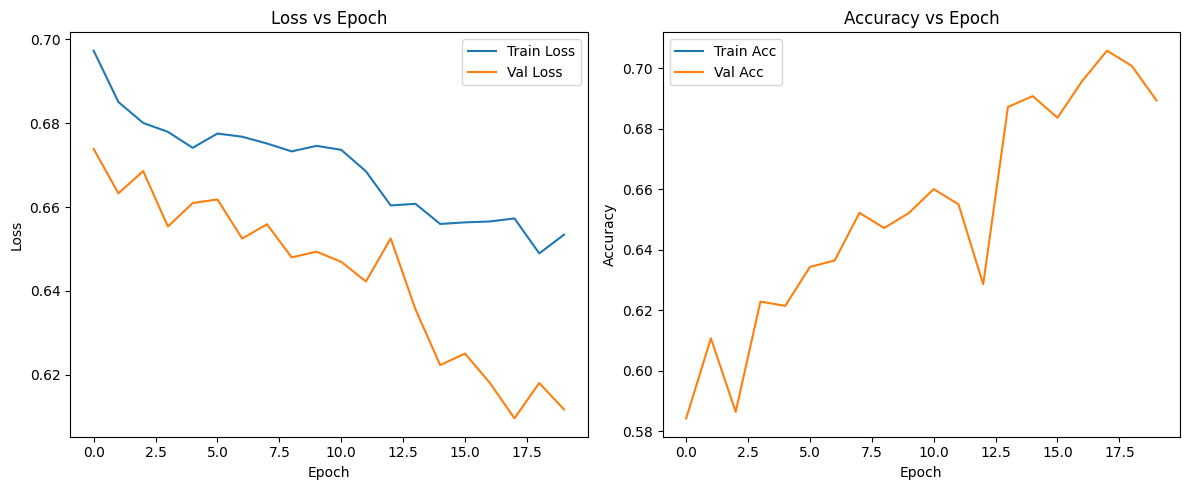

In [ ]:
# ViT + ConvNeXt Hybrid with Mixup, Gradual Unfreezing, and Full Metrics

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
import time
from timm.data import Mixup
from transformers import ViTModel
import timm

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_ConvNeXt_Hybrid(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.convnext = timm.create_model('convnext_base', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.convnext.parameters(): p.requires_grad = False
        vit_dim, convnext_dim = self.vit.config.hidden_size, self.convnext.head.in_features
        self.convnext.head = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + convnext_dim, 512), nn.ReLU(), nn.Dropout(dropout), nn.Linear(512, num_classes))

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).pooler_output
        conv_feat = torch.mean(self.convnext(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, conv_feat), dim=1))

# === Optimizer ===
def get_optimizer(model, base_lr=1e-4, weight_decay=1e-3):
    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if param.requires_grad:
            (no_decay if 'bias' in name or 'norm' in name else decay).append(param)
    return optim.AdamW([
        {'params': decay, 'weight_decay': weight_decay},
        {'params': no_decay, 'weight_decay': 0.0}], lr=base_lr)

# === Train/Eval ===
def train_epoch(model, loader, criterion, opt, device, scaler, mixup_fn=None):
    model.train(); loss_sum = correct = total = 0; start = time.time()
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        if mixup_fn: imgs, labels = mixup_fn(imgs, labels)
        opt.zero_grad()
        with autocast():
            out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        if not mixup_fn: correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)
    acc = correct / total if not mixup_fn else None
    return loss_sum / total, acc, time.time() - start

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                out = model(imgs); loss = criterion(out, labels)
                probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    return loss_sum / total, correct / total, prec, rec, f1, roc, cm

# === Unfreeze ===
def gradual_unfreeze(epoch, model, optimizer):
    if epoch == 5:
        print("Unfreezing last ViT layers...")
        for name, param in model.vit.named_parameters():
            if 'encoder.layer.10' in name or 'encoder.layer.11' in name:
                param.requires_grad = True
        optimizer.add_param_group({'params': [p for n, p in model.vit.named_parameters() if p.requires_grad], 'lr': 1e-5})
    elif epoch == 8:
        print("Unfreezing all ViT...")
        for p in model.vit.parameters(): p.requires_grad = True
    elif epoch == 10:
        print("Unfreezing ConvNeXt...")
        for p in model.convnext.parameters(): p.requires_grad = True
        optimizer.add_param_group({'params': model.convnext.parameters(), 'lr': 1e-5})

# === Main Training ===
def run_training(npz_file, batch_size=16, num_epochs=15, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_ConvNeXt_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_optimizer(model)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    scaler = GradScaler()
    mixup_fn = Mixup(0.8, 1.0, prob=1.0, switch_prob=0.5, label_smoothing=0.1, num_classes=2)

    best_val_loss, counter = float('inf'), 0
    train_losses, val_losses, train_accs, val_accs, times = [], [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        gradual_unfreeze(epoch, model, optimizer)
        train_loss, train_acc, time_elapsed = train_epoch(model, train_loader, criterion, optimizer, device, scaler, mixup_fn)
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc); times.append(time_elapsed)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc if train_acc is not None else 'Mixup'} | Time: {time_elapsed:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_vit_convnext_hybrid.pth')
        else:
            counter += 1
            if counter >= 6:
                print("Early stopping triggered."); break

    model.eval()
    with torch.no_grad():
        start_inf = time.time()
        _ = model(torch.randn(1, 3, 224, 224).to(device))
        print(f"\nInference Time (1 sample): {(time.time() - start_inf) * 1000:.2f} ms")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz', batch_size=16, num_epochs=20)


## ViT + MaxViT Hybrid

2025-05-20 20:22:11.171167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747772531.382701      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747772531.442092      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

/tmp/ipykernel_35/739949252.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable parameters: 787970

Epoch 1/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:17<00:00,  5.03it/s]


Train Loss: 1.0208 | Train Acc: 0.5713 | Time: 69.74s
Val Loss: 0.7027 | Val Acc: 0.6250
Precision: 0.6171 | Recall: 0.7188 | F1: 0.6641 | ROC-AUC: 0.6716
CM:
[[356 322]
 [203 519]]

Epoch 2/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.86it/s]


Train Loss: 0.6956 | Train Acc: 0.5984 | Time: 71.12s
Val Loss: 0.7776 | Val Acc: 0.6271
Precision: 0.6792 | Recall: 0.5249 | F1: 0.5922 | ROC-AUC: 0.6827
CM:
[[499 179]
 [343 379]]

Epoch 3/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.75it/s]


Train Loss: 0.6605 | Train Acc: 0.6261 | Time: 73.47s
Val Loss: 0.7027 | Val Acc: 0.6464
Precision: 0.6548 | Recall: 0.6648 | F1: 0.6598 | ROC-AUC: 0.6867
CM:
[[425 253]
 [242 480]]

Epoch 4/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.72it/s]


Train Loss: 0.6594 | Train Acc: 0.6271 | Time: 74.40s
Val Loss: 0.6635 | Val Acc: 0.6207
Precision: 0.6278 | Recall: 0.6496 | F1: 0.6385 | ROC-AUC: 0.6681
CM:
[[400 278]
 [253 469]]

Epoch 5/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.71it/s]


Train Loss: 0.6523 | Train Acc: 0.6407 | Time: 74.50s
Val Loss: 0.6629 | Val Acc: 0.6643
Precision: 0.6869 | Recall: 0.6413 | F1: 0.6633 | ROC-AUC: 0.7121
CM:
[[467 211]
 [259 463]]

Epoch 6/20
Unfreezing ViT...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.6499 | Train Acc: 0.6448 | Time: 114.70s
Val Loss: 0.6501 | Val Acc: 0.6343
Precision: 0.6382 | Recall: 0.6717 | F1: 0.6545 | ROC-AUC: 0.6887
CM:
[[403 275]
 [237 485]]

Epoch 7/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.6538 | Train Acc: 0.6382 | Time: 114.87s
Val Loss: 0.6593 | Val Acc: 0.6586
Precision: 0.6685 | Recall: 0.6704 | F1: 0.6694 | ROC-AUC: 0.7161
CM:
[[438 240]
 [238 484]]

Epoch 8/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.6425 | Train Acc: 0.6587 | Time: 115.09s
Val Loss: 0.6372 | Val Acc: 0.6650
Precision: 0.6636 | Recall: 0.7105 | F1: 0.6863 | ROC-AUC: 0.7144
CM:
[[418 260]
 [209 513]]

Epoch 9/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.6361 | Train Acc: 0.6680 | Time: 114.84s
Val Loss: 0.6322 | Val Acc: 0.6643
Precision: 0.7045 | Recall: 0.6011 | F1: 0.6487 | ROC-AUC: 0.7343
CM:
[[496 182]
 [288 434]]

Epoch 10/20
Unfreezing MaxViT...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.6284 | Train Acc: 0.6818 | Time: 238.30s
Val Loss: 0.6171 | Val Acc: 0.6936
Precision: 0.6806 | Recall: 0.7645 | F1: 0.7202 | ROC-AUC: 0.7529
CM:
[[419 259]
 [170 552]]

Epoch 11/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.68it/s]


Train Loss: 0.6142 | Train Acc: 0.7009 | Time: 238.05s
Val Loss: 0.6258 | Val Acc: 0.6814
Precision: 0.7323 | Recall: 0.6025 | F1: 0.6611 | ROC-AUC: 0.7499
CM:
[[519 159]
 [287 435]]

Epoch 12/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:19<00:00,  4.42it/s]


Train Loss: 0.6113 | Train Acc: 0.7009 | Time: 252.69s
Val Loss: 0.6199 | Val Acc: 0.6871
Precision: 0.7630 | Recall: 0.5706 | F1: 0.6529 | ROC-AUC: 0.7544
CM:
[[550 128]
 [310 412]]

Epoch 13/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:20<00:00,  4.35it/s]


Train Loss: 0.6075 | Train Acc: 0.7009 | Time: 253.15s
Val Loss: 0.6095 | Val Acc: 0.7000
Precision: 0.7459 | Recall: 0.6343 | F1: 0.6856 | ROC-AUC: 0.7649
CM:
[[522 156]
 [264 458]]

Epoch 14/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:20<00:00,  4.39it/s]


Train Loss: 0.6023 | Train Acc: 0.7011 | Time: 253.06s
Val Loss: 0.6063 | Val Acc: 0.7029
Precision: 0.7155 | Recall: 0.7036 | F1: 0.7095 | ROC-AUC: 0.7607
CM:
[[476 202]
 [214 508]]

Epoch 15/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.64it/s]


Train Loss: 0.5983 | Train Acc: 0.7114 | Time: 247.34s
Val Loss: 0.6081 | Val Acc: 0.6971
Precision: 0.7064 | Recall: 0.7064 | F1: 0.7064 | ROC-AUC: 0.7585
CM:
[[466 212]
 [212 510]]

Epoch 16/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.5929 | Train Acc: 0.7121 | Time: 239.16s
Val Loss: 0.6040 | Val Acc: 0.6879
Precision: 0.6918 | Recall: 0.7119 | F1: 0.7017 | ROC-AUC: 0.7665
CM:
[[449 229]
 [208 514]]

Epoch 17/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.5997 | Train Acc: 0.7121 | Time: 238.25s
Val Loss: 0.6328 | Val Acc: 0.6671
Precision: 0.7735 | Recall: 0.5014 | F1: 0.6084 | ROC-AUC: 0.7574
CM:
[[572 106]
 [360 362]]

Epoch 18/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.5978 | Train Acc: 0.7182 | Time: 237.81s
Val Loss: 0.6058 | Val Acc: 0.6886
Precision: 0.7061 | Recall: 0.6787 | F1: 0.6921 | ROC-AUC: 0.7618
CM:
[[474 204]
 [232 490]]

Epoch 19/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.5893 | Train Acc: 0.7200 | Time: 238.10s
Val Loss: 0.6115 | Val Acc: 0.6957
Precision: 0.6942 | Recall: 0.7327 | F1: 0.7129 | ROC-AUC: 0.7580
CM:
[[445 233]
 [193 529]]

Epoch 20/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/739949252.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.5843 | Train Acc: 0.7268 | Time: 238.09s
Val Loss: 0.6193 | Val Acc: 0.6929
Precision: 0.7674 | Recall: 0.5803 | F1: 0.6609 | ROC-AUC: 0.7604
CM:
[[551 127]
 [303 419]]

Inference Time (1 sample): 276.11 ms


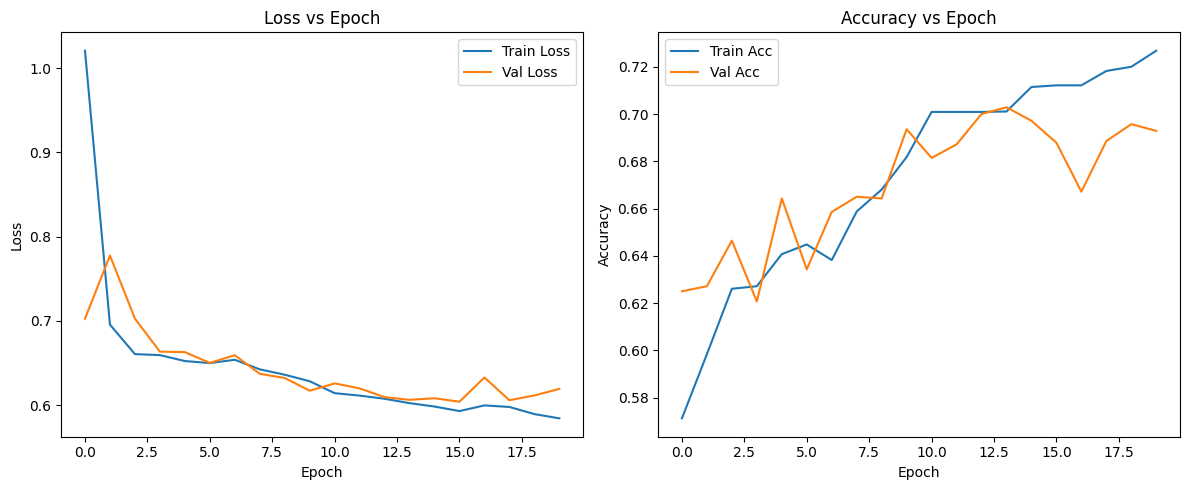

In [ ]:
# ViT + MaxViT Hybrid Training with Full Metrics and Gradual Unfreezing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from transformers import ViTModel
import timm
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_MaxViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + maxvit_dim, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

# === Train/Eval ===
def train_epoch(model, loader, criterion, opt, device, scaler):
    model.train(); loss_sum = correct = total = 0; start = time.time()
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        with autocast():
            out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item(); total += labels.size(0)
    return loss_sum / total, correct / total, time.time() - start

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                out = model(imgs); loss = criterion(out, labels)
                probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return loss_sum / total, correct / total, precision_score(all_labels, all_preds), \
           recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), \
           roc_auc_score(all_labels, all_probs), confusion_matrix(all_labels, all_preds)

# === Unfreeze ===
def unfreeze_layers(model, vit=False, maxvit=False):
    if vit:
        for p in model.vit.parameters(): p.requires_grad = True
    if maxvit:
        for p in model.maxvit.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

# === Main Loop ===
def run_training(npz_file, batch_size=16, num_epochs=15, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_MaxViT_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    unfreeze_layers(model, vit=False, maxvit=False)
    best_val_loss, counter = float('inf'), 0
    train_losses, val_losses, train_accs, val_accs, times = [], [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        if epoch == 5:
            print("Unfreezing ViT..."); unfreeze_layers(model, vit=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.vit.parameters()), 'lr': 1e-5})
        elif epoch == 9:
            print("Unfreezing MaxViT..."); unfreeze_layers(model, vit=True, maxvit=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.maxvit.parameters()), 'lr': 1e-5})

        train_loss, train_acc, duration = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc); times.append(duration)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {duration:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        scheduler.step(epoch + val_loss)
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_vit_maxvit_hybrid.pth')
        else:
            counter += 1
            if counter >= 5:
                print("Early stopping triggered."); break

    model.eval()
    with torch.no_grad():
        t0 = time.time(); _ = model(torch.randn(1, 3, 224, 224).to(device)); t1 = time.time()
        print(f"\nInference Time (1 sample): {(t1 - t0) * 1000:.2f} ms")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz', batch_size=16, num_epochs=20)


## ViT + Swin Hybrid

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

/tmp/ipykernel_35/849553342.py:147: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable Parameters: 919042
Epoch 1/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.84it/s]


Train Loss: 0.6447 | Train Acc: 0.6257 | Time: 44.43s
Val Loss: 0.6242 | Val Acc: 0.6507
Precision: 0.6837 | Recall: 0.6213 | F1: 0.6510 | ROC-AUC: 0.7127
Confusion Matrix:
[[455 211]
 [278 456]]

Epoch 2/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.68it/s]


Train Loss: 0.6241 | Train Acc: 0.6543 | Time: 45.71s
Val Loss: 0.6198 | Val Acc: 0.6600
Precision: 0.6943 | Recall: 0.6281 | F1: 0.6595 | ROC-AUC: 0.7199
Confusion Matrix:
[[463 203]
 [273 461]]

Epoch 3/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.54it/s]


Train Loss: 0.6186 | Train Acc: 0.6613 | Time: 46.51s
Val Loss: 0.6140 | Val Acc: 0.6764
Precision: 0.7081 | Recall: 0.6512 | F1: 0.6785 | ROC-AUC: 0.7293
Confusion Matrix:
[[469 197]
 [256 478]]

Epoch 4/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.47it/s]


Train Loss: 0.6112 | Train Acc: 0.6721 | Time: 47.17s
Val Loss: 0.6095 | Val Acc: 0.6786
Precision: 0.6924 | Recall: 0.6962 | F1: 0.6943 | ROC-AUC: 0.7314
Confusion Matrix:
[[439 227]
 [223 511]]

Epoch 5/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.47it/s]


Train Loss: 0.6124 | Train Acc: 0.6704 | Time: 47.37s
Val Loss: 0.6193 | Val Acc: 0.6836
Precision: 0.7539 | Recall: 0.5886 | F1: 0.6611 | ROC-AUC: 0.7362
Confusion Matrix:
[[525 141]
 [302 432]]

Epoch 6/20
Unfreezing ViT backbone...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.48it/s]


Train Loss: 0.6171 | Train Acc: 0.6684 | Time: 87.72s
Val Loss: 0.6151 | Val Acc: 0.6593
Precision: 0.7063 | Recall: 0.5995 | F1: 0.6485 | ROC-AUC: 0.7300
Confusion Matrix:
[[483 183]
 [294 440]]

Epoch 7/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.42it/s]


Train Loss: 0.5946 | Train Acc: 0.6813 | Time: 87.82s
Val Loss: 0.6066 | Val Acc: 0.6764
Precision: 0.7443 | Recall: 0.5831 | F1: 0.6539 | ROC-AUC: 0.7512
Confusion Matrix:
[[519 147]
 [306 428]]

Epoch 8/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.45it/s]


Train Loss: 0.5728 | Train Acc: 0.7127 | Time: 87.95s
Val Loss: 0.5904 | Val Acc: 0.6986
Precision: 0.7254 | Recall: 0.6839 | F1: 0.7041 | ROC-AUC: 0.7562
Confusion Matrix:
[[476 190]
 [232 502]]

Epoch 9/20
Unfreezing Swin backbone...


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.44it/s]


Train Loss: 0.5388 | Train Acc: 0.7391 | Time: 149.20s
Val Loss: 0.6009 | Val Acc: 0.6707
Precision: 0.6987 | Recall: 0.6540 | F1: 0.6756 | ROC-AUC: 0.7471
Confusion Matrix:
[[459 207]
 [254 480]]

Epoch 10/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:11<00:00,  7.44it/s]


Train Loss: 0.4694 | Train Acc: 0.7857 | Time: 149.31s
Val Loss: 0.6432 | Val Acc: 0.6779
Precision: 0.7207 | Recall: 0.6294 | F1: 0.6720 | ROC-AUC: 0.7241
Confusion Matrix:
[[487 179]
 [272 462]]

Epoch 11/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:12<00:00,  6.81it/s]


Train Loss: 0.3964 | Train Acc: 0.8320 | Time: 150.28s
Val Loss: 0.7123 | Val Acc: 0.6579
Precision: 0.6367 | Recall: 0.8093 | F1: 0.7127 | ROC-AUC: 0.7226
Confusion Matrix:
[[327 339]
 [140 594]]

Epoch 12/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:12<00:00,  6.94it/s]


Train Loss: 0.2887 | Train Acc: 0.8800 | Time: 156.54s
Val Loss: 0.8542 | Val Acc: 0.6571
Precision: 0.6913 | Recall: 0.6253 | F1: 0.6567 | ROC-AUC: 0.7058
Confusion Matrix:
[[461 205]
 [275 459]]

Epoch 13/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/849553342.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 88/88 [00:12<00:00,  6.98it/s]


Train Loss: 0.1440 | Train Acc: 0.9480 | Time: 156.06s
Val Loss: 1.1620 | Val Acc: 0.6471
Precision: 0.6905 | Recall: 0.5926 | F1: 0.6378 | ROC-AUC: 0.6969
Confusion Matrix:
[[471 195]
 [299 435]]

Early stopping triggered.

Average Inference Time (1 sample): 44.74 ms


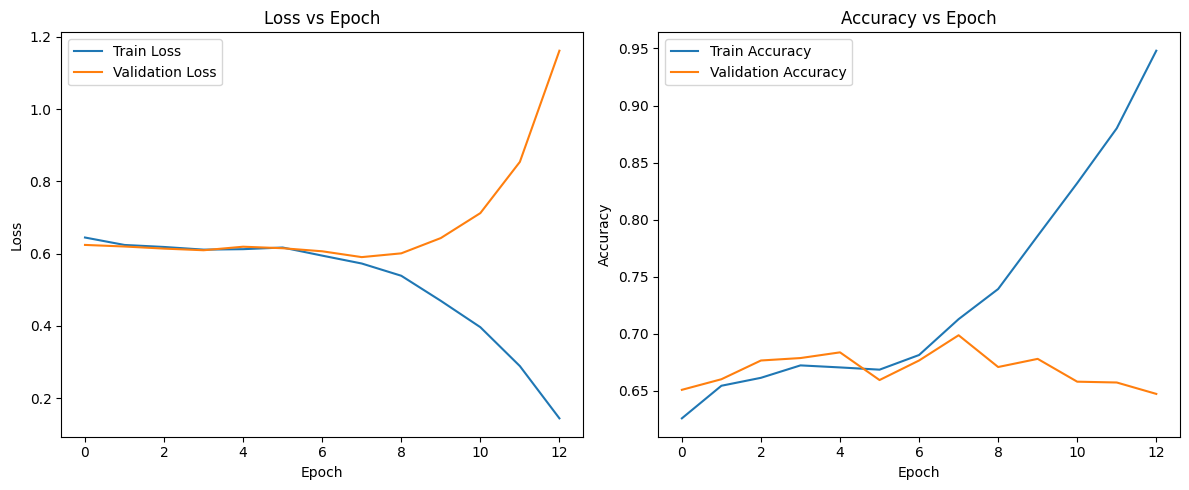

In [ ]:
# Hybrid ViT + Swin Model with Metrics Tracking

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from transformers import ViTModel, SwinModel
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        img = self.transform(img)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label

# === Hybrid Model ===
class ViT_Swin_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT_Swin_Hybrid, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.swin = SwinModel.from_pretrained("microsoft/swin-base-patch4-window7-224")

        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.swin.parameters():
            param.requires_grad = False

        vit_dim = self.vit.config.hidden_size
        swin_dim = self.swin.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + swin_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x).pooler_output
        swin_outputs = self.swin(pixel_values=x).pooler_output
        combined = torch.cat((vit_outputs, swin_outputs), dim=1)
        return self.classifier(combined)

# === Train/Eval Functions ===
def train_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start_time = time.time()

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    end_time = time.time()
    return running_loss / total, correct / total, end_time - start_time

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                probs = nn.functional.softmax(outputs, dim=1)[:, 1]

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    return running_loss / total, correct / total, precision, recall, f1, roc_auc, cm

# === Unfreezing ===
def unfreeze_layers(model, unfreeze_vit=False, unfreeze_swin=False):
    if unfreeze_vit:
        for param in model.vit.parameters():
            param.requires_grad = True
    if unfreeze_swin:
        for param in model.swin.parameters():
            param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

# === Training Loop ===
def run_training(npz_file, batch_size=16, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_file)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_Swin_Hybrid(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    scaler = GradScaler()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_times = []

    unfreeze_layers(model, unfreeze_vit=False, unfreeze_swin=False)

    print("Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

    best_val_loss, counter, patience = float('inf'), 0, 5

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        if epoch == 5:
            print("Unfreezing ViT backbone...")
            unfreeze_layers(model, unfreeze_vit=True, unfreeze_swin=False)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.vit.parameters()), 'lr': 1e-5})
        elif epoch == 8:
            print("Unfreezing Swin backbone...")
            unfreeze_layers(model, unfreeze_vit=True, unfreeze_swin=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.swin.parameters()), 'lr': 1e-5})

        train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc_auc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_times.append(train_time)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_vit_swin_hybrid.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Inference Time
    model.eval()
    sample = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        start_inf = time.time()
        _ = model(sample)
        end_inf = time.time()
        print(f"\nAverage Inference Time (1 sample): {(end_inf - start_inf) * 1000:.2f} ms")

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    npz_path = '/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    run_training(npz_path, batch_size=16, num_epochs=20, device=device)


## ViT + CoAtNet Hybrid

In [ ]:
# ViT + CoAtNet Hybrid Training Script

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from transformers import ViTModel
import timm
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.75, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.4, 0.4, 0.3, 0.15),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_CoAtNet_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.coatnet = timm.create_model('coatnet_0_rw_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.coatnet.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        coatnet_dim = self.coatnet.head.in_features
        self.coatnet.head = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + coatnet_dim, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Dropout(0.4), nn.Linear(512, num_classes))

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        coat_feat = torch.mean(self.coatnet.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, coat_feat), dim=1))

# === Optimizer ===
def get_optimizer(model, base_lr=2e-4, weight_decay=1e-2):
    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if param.requires_grad:
            (no_decay if 'bias' in name or 'norm' in name else decay).append(param)
    return optim.AdamW([
        {'params': decay, 'weight_decay': weight_decay},
        {'params': no_decay, 'weight_decay': 0.0}], lr=base_lr)

# === Training and Evaluation ===
def train_epoch(model, loader, criterion, opt, device, scaler):
    model.train(); loss_sum = correct = total = 0; start = time.time()
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        with autocast(): out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item(); total += labels.size(0)
    return loss_sum / total, correct / total, time.time() - start

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(): out = model(imgs); loss = criterion(out, labels)
            probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item(); total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return loss_sum / total, correct / total, precision_score(all_labels, all_preds), \
           recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), \
           roc_auc_score(all_labels, all_probs), confusion_matrix(all_labels, all_preds)

# === Main Training ===
def run_training(npz_file, batch_size=16, num_epochs=20, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_CoAtNet_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = get_optimizer(model)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc, train_time = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Time: {train_time:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")
        scheduler.step(epoch + val_loss)

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')

2025-05-21 11:10:25.074140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747825825.244273      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747825825.295415      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

/tmp/ipykernel_36/1834637678.py:118: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Trainable parameters: 788994

Epoch 1/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.95it/s]


Train Loss: 0.7195 | Acc: 0.5893 | Time: 30.08s
Val Loss: 0.6751 | Val Acc: 0.6236 | Precision: 0.6600 | Recall: 0.5508 | F1: 0.6005 | ROC-AUC: 0.6676
CM:
[[477 204]
 [323 396]]

Epoch 2/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.93it/s]


Train Loss: 0.6725 | Acc: 0.6207 | Time: 28.87s
Val Loss: 0.6577 | Val Acc: 0.6236 | Precision: 0.6319 | Recall: 0.6398 | F1: 0.6358 | ROC-AUC: 0.6754
CM:
[[413 268]
 [259 460]]

Epoch 3/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.35it/s]


Train Loss: 0.6590 | Acc: 0.6300 | Time: 29.93s
Val Loss: 0.6507 | Val Acc: 0.6429 | Precision: 0.6337 | Recall: 0.7218 | F1: 0.6749 | ROC-AUC: 0.6889
CM:
[[381 300]
 [200 519]]

Epoch 4/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:08<00:00, 10.93it/s]


Train Loss: 0.6494 | Acc: 0.6488 | Time: 31.89s
Val Loss: 0.6507 | Val Acc: 0.6536 | Precision: 0.6657 | Recall: 0.6537 | F1: 0.6596 | ROC-AUC: 0.6923
CM:
[[445 236]
 [249 470]]

Epoch 5/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.18it/s]


Train Loss: 0.6472 | Acc: 0.6382 | Time: 31.26s
Val Loss: 0.6465 | Val Acc: 0.6407 | Precision: 0.6350 | Recall: 0.7065 | F1: 0.6689 | ROC-AUC: 0.6919
CM:
[[389 292]
 [211 508]]

Epoch 6/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.02it/s]


Train Loss: 0.6439 | Acc: 0.6454 | Time: 31.49s
Val Loss: 0.6473 | Val Acc: 0.6493 | Precision: 0.6579 | Recall: 0.6606 | F1: 0.6593 | ROC-AUC: 0.6973
CM:
[[434 247]
 [244 475]]

Epoch 7/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.14it/s]


Train Loss: 0.6542 | Acc: 0.6395 | Time: 31.46s
Val Loss: 0.6476 | Val Acc: 0.6500 | Precision: 0.6566 | Recall: 0.6676 | F1: 0.6621 | ROC-AUC: 0.6932
CM:
[[430 251]
 [239 480]]

Epoch 8/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.17it/s]


Train Loss: 0.6489 | Acc: 0.6418 | Time: 31.38s
Val Loss: 0.6538 | Val Acc: 0.6400 | Precision: 0.6467 | Recall: 0.6592 | F1: 0.6529 | ROC-AUC: 0.6893
CM:
[[422 259]
 [245 474]]

Epoch 9/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.06it/s]


Train Loss: 0.6452 | Acc: 0.6462 | Time: 31.57s
Val Loss: 0.6485 | Val Acc: 0.6371 | Precision: 0.6672 | Recall: 0.5855 | F1: 0.6237 | ROC-AUC: 0.6968
CM:
[[471 210]
 [298 421]]

Epoch 10/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.07it/s]


Train Loss: 0.6473 | Acc: 0.6495 | Time: 31.51s
Val Loss: 0.6509 | Val Acc: 0.6314 | Precision: 0.6436 | Recall: 0.6328 | F1: 0.6381 | ROC-AUC: 0.6908
CM:
[[429 252]
 [264 455]]

Epoch 11/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.10it/s]


Train Loss: 0.6403 | Acc: 0.6488 | Time: 31.60s
Val Loss: 0.6542 | Val Acc: 0.6350 | Precision: 0.6605 | Recall: 0.5953 | F1: 0.6262 | ROC-AUC: 0.6924
CM:
[[461 220]
 [291 428]]

Epoch 12/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.12it/s]


Train Loss: 0.6400 | Acc: 0.6498 | Time: 31.51s
Val Loss: 0.6389 | Val Acc: 0.6514 | Precision: 0.6584 | Recall: 0.6676 | F1: 0.6630 | ROC-AUC: 0.7109
CM:
[[432 249]
 [239 480]]

Epoch 13/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.12it/s]


Train Loss: 0.6412 | Acc: 0.6496 | Time: 31.47s
Val Loss: 0.6450 | Val Acc: 0.6464 | Precision: 0.6538 | Recall: 0.6620 | F1: 0.6579 | ROC-AUC: 0.6946
CM:
[[429 252]
 [243 476]]

Epoch 14/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.11it/s]


Train Loss: 0.6348 | Acc: 0.6568 | Time: 31.46s
Val Loss: 0.6426 | Val Acc: 0.6364 | Precision: 0.6438 | Recall: 0.6537 | F1: 0.6487 | ROC-AUC: 0.6983
CM:
[[421 260]
 [249 470]]

Epoch 15/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.07it/s]


Train Loss: 0.6374 | Acc: 0.6613 | Time: 31.51s
Val Loss: 0.6333 | Val Acc: 0.6679 | Precision: 0.6759 | Recall: 0.6787 | F1: 0.6773 | ROC-AUC: 0.7179
CM:
[[447 234]
 [231 488]]

Epoch 16/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.10it/s]


Train Loss: 0.6326 | Acc: 0.6646 | Time: 31.56s
Val Loss: 0.6377 | Val Acc: 0.6621 | Precision: 0.6662 | Recall: 0.6857 | F1: 0.6758 | ROC-AUC: 0.7109
CM:
[[434 247]
 [226 493]]

Epoch 17/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.11it/s]


Train Loss: 0.6420 | Acc: 0.6539 | Time: 31.52s
Val Loss: 0.6466 | Val Acc: 0.6407 | Precision: 0.6410 | Recall: 0.6829 | F1: 0.6613 | ROC-AUC: 0.6915
CM:
[[406 275]
 [228 491]]

Epoch 18/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.09it/s]


Train Loss: 0.6425 | Acc: 0.6541 | Time: 31.47s
Val Loss: 0.6483 | Val Acc: 0.6407 | Precision: 0.6456 | Recall: 0.6662 | F1: 0.6557 | ROC-AUC: 0.6950
CM:
[[418 263]
 [240 479]]

Epoch 19/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.02it/s]


Train Loss: 0.6426 | Acc: 0.6471 | Time: 31.48s
Val Loss: 0.6442 | Val Acc: 0.6579 | Precision: 0.6635 | Recall: 0.6773 | F1: 0.6703 | ROC-AUC: 0.7008
CM:
[[434 247]
 [232 487]]

Epoch 20/20


  0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
  0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_36/1834637678.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(imgs); loss = criterion(out, labels)
100%|██████████| 88/88 [00:07<00:00, 11.11it/s]

Train Loss: 0.6420 | Acc: 0.6552 | Time: 31.47s
Val Loss: 0.6465 | Val Acc: 0.6493 | Precision: 0.6754 | Recall: 0.6106 | F1: 0.6413 | ROC-AUC: 0.6951
CM:
[[470 211]
 [280 439]]


## ViT + ConvNeXt + Swin Hybrid Model

In [ ]:
# ViT + ConvNeXt + Swin Hybrid Model

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.cuda.amp import autocast, GradScaler
from transformers import ViTModel
import timm

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Hybrid Model ===
class ViT_ConvNeXt_Swin_Hybrid(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.convnext = timm.create_model('convnext_base', pretrained=True)
        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

        for m in [self.vit, self.convnext, self.swin]:
            for p in m.parameters():
                p.requires_grad = False

        self.convnext.head = nn.Identity()
        self.swin.head = nn.Identity()

        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            vit_dim = self.vit(dummy_input).pooler_output.shape[1]
            conv_dim = torch.nn.functional.adaptive_avg_pool2d(
                self.convnext.forward_features(dummy_input), 1).flatten(1).shape[1]
            swin_dim = torch.nn.functional.adaptive_avg_pool2d(
                self.swin.forward_features(dummy_input), 1).flatten(1).shape[1]
            self.total_dim = vit_dim + conv_dim + swin_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.total_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_out = self.vit(pixel_values=x).pooler_output
        conv_feat = torch.nn.functional.adaptive_avg_pool2d(self.convnext.forward_features(x), 1).flatten(1)
        swin_feat = torch.nn.functional.adaptive_avg_pool2d(self.swin.forward_features(x), 1).flatten(1)
        combined = torch.cat((vit_out, conv_feat, swin_feat), dim=1)
        return self.classifier(combined)

# === Train / Eval Functions ===
def train_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train(); loss_sum = correct = total = 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return loss_sum / total, correct / total

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                out = model(imgs); loss = criterion(out, labels)
                probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    return loss_sum / total, correct / total, prec, rec, f1, roc, cm

# === Training Driver ===
def run_training(npz_file, batch_size=16, num_epochs=15, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_ConvNeXt_Swin_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    scaler = GradScaler()

    best_val_loss, counter = float('inf'), 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_vit_convnext_swin_hybrid.pth')
        else:
            counter += 1
            if counter >= 5:
                print("Early stopping triggered."); break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
